In [1]:
import wandb
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

img_name = "icml_overall_" + datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")

entity = "jaesikyoon"
project = "ocrl-agentlearning"
default_tags = ["toplot", "sparserewtype", "hardmode"]

# envs
envs = [
        [
            "targetN4C4S3S1",
            "pushN3C4S1S1",
        ],
        [
            "oddoneoutN4C2S2S1oc",
            "oddoneoutN4C2S2S1",
        ]
]
envs = np.array(envs)

# titles
titles = [
        [
            "Object Goal Task",
            "Object Interaction Task",
        ],
        [
            "Object Comparison Task",
            "Property Comparison Task",
        ],
        ]

# colormap
cm = plt.cm.get_cmap("tab20").colors
#import distinctipy
#cm = distinctipy.get_colors(7,pastel_factor=0.1, colorblind_type="Deuteranomaly")
# models
models = {
    "GT": {
        "tags": ["gt"],
        "line_cm": cm[2],
        "range_cm": cm[3],
        "marker": "o",
        "fill_style": "full",
        "line_style": "dotted",
    },
    "Single-Vector Rep. E2E Learning": {
        "tags": ["end-to-end learning", "distributed representation"],
        "line_cm": cm[4],
        "range_cm": cm[5],
        "marker": "v",
        "fill_style": "full",
        "line_style": "dashed",
    },
    "Fixed-Region Rep. E2E Learning": {
        "tags": ["end-to-end learning", "region representation"],
        "line_cm": cm[6],
        "range_cm": cm[7],
        "marker": "v",
        "full_style": "full",
        "line_style": "dashed",
    },
    "OCR E2E Learning": {
        "tags": ["end-to-end learning", "ocr"],
        "line_cm": cm[8],
        "range_cm": cm[9],
        "marker": "v",
        "full_style": "full",
        "line_style": "dashed",
    },
    "Single-Vector Rep. Pretraining": {
        "tags": ["pretraining", "distributed representation"],
        "line_cm": cm[10],
        "range_cm": cm[11],
        "marker": "v",
        "full_style": "full",
        "line_style": "dashed",
    },
    "Fixed-Region Rep. Pretraining": {
        "tags": ["pretraining", "region representation"],
        "line_cm": cm[12],
        "range_cm": cm[13],
        "marker": "v",
        "full_style": "full",
        "line_style": "dashed",
    },
    "OCR Pretraining": {
        "tags": ["pretraining", "ocr"],
        "line_cm": cm[14],
        "range_cm": cm[15],
        "marker": "v",
        "full_style": "full",
        "line_style": "dashed",
    }
}
print(f"Models: {models.keys()}")

api = wandb.Api(timeout=19)
results = {}
for i in range(envs.shape[0]):
    for j in range(envs.shape[1]):
        for model_name, model_infos in models.items():
            filters = []
            filters.append({"tags": envs[i,j]})
            for model_tag in model_infos["tags"]:
                filters.append({"tags": model_tag})
            for default_tag in default_tags:
                filters.append({"tags": default_tag})
            #print(filters)
            runs = api.runs(f"{entity}/{project}", filters={"$and": filters})
            global_steps = []
            success_rates = []
            for run in runs:
                #print(run)
                history = run.scan_history(["global_step","eval/success_rate"])
                _global_step = []
                _success_rate = []
                for row in history:
                    _global_step.append(row["global_step"])
                    _success_rate.append(row["eval/success_rate"])
                global_steps.append(_global_step)
                success_rates.append(_success_rate)
            if model_name == "OCR Pretraining" and (envs[i,j] == "pushN3C4S1S1" or envs[i,j] == "oddoneoutN4C2S2S1oc"):
                runs = api.runs(f"jaesikyoon/ocrl-rl", filters={"$and": filters})
                for run in runs:
                    #print(run)
                    history = run.scan_history(["global_step","eval/success_rate"])
                    _global_step = []
                    _success_rate = []
                    for row in history:
                        _global_step.append(row["global_step"])
                        _success_rate.append(row["eval/success_rate"])
                    global_steps.append(_global_step)
                    success_rates.append(_success_rate)
            if len(global_steps) == 0:  # no logs
                continue
            step = 2000000 // 4000
            # success rates
            for rate_idx in range(len(success_rates)):
                success_rates[rate_idx] = success_rates[rate_idx][:step]
                if len(success_rates[rate_idx]) < 500:
                    success_rates[rate_idx] += [success_rates[rate_idx][-1]] * (500-len(success_rates[rate_idx]))
            sr_steps = global_steps[-1][:step]
            success_rates = np.array(success_rates)
            sr_mean = np.mean(success_rates[:,-10:])
            sr_max = np.max(np.mean(success_rates[:,-10:], axis=-1)) - sr_mean
            sr_min = sr_mean - np.min(np.mean(success_rates[:,-10:], axis=-1))
            sr_std = np.std(success_rates[:,-10:])
            if not model_name in results.keys():
                results[model_name] = {"mean": [], "max": [], "min": [], "std": []}
            results[model_name]["mean"].append(sr_mean)
            results[model_name]["max"].append(sr_max)
            results[model_name]["min"].append(sr_min)
            results[model_name]["std"].append(sr_std)

Models: dict_keys(['GT', 'Single-Vector Rep. E2E Learning', 'Fixed-Region Rep. E2E Learning', 'OCR E2E Learning', 'Single-Vector Rep. Pretraining', 'Fixed-Region Rep. Pretraining', 'OCR Pretraining'])


In [2]:
results
import json
with open("results/regime_wise_performances.json", "w") as f:
    json.dump(results, f)

[0.010666671395301863, 0.0759999990463257]
GT [0.9743333429098129, 0.7949999988079071] [0.010666671395301863, 0.0759999990463257] [0.01833334863185876, 0.09300000071525572]
[0.0016666611035663914, 0.012000000476837136]
Single-Vector Rep. E2E Learning [0.9873333434263866, 0.7840000033378601] [0.0016666611035663914, 0.012000000476837136] [0.0013333300749461818, 0.01800000071525576]
[0.005666669209798192, 0.5249999980752666]
Fixed-Region Rep. E2E Learning [0.9763333419958751, 0.2909999985868732] [0.005666669209798192, 0.5249999980752666] [0.004333333174387666, 0.2639999990041057]
[0.007333342234293605, 0.1360000004371007]
OCR E2E Learning [0.9736666758855184, 0.48999999860922494] [0.007333342234293605, 0.1360000004371007] [0.009666671355565315, 0.10100000003973642]
[0.24733333686987558, 0.23166667114322384]
Single-Vector Rep. Pretraining [0.6756666650374731, 0.23433333445961277] [0.24733333686987558, 0.23166667114322384] [0.23066667219003045, 0.2163333346756796]
[0.004666668176650957, 0.0

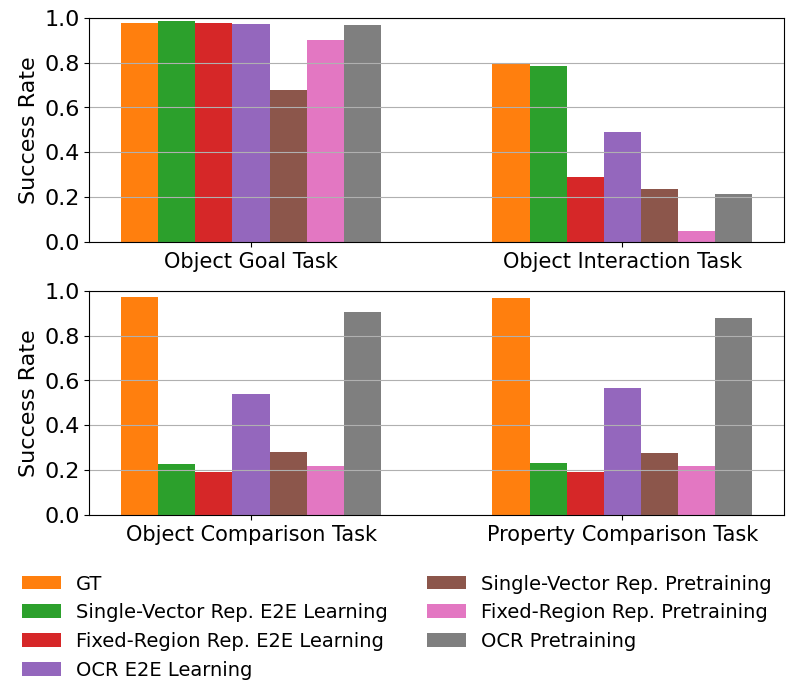

In [8]:
# plots
top = 0.03
hspace = 0.07
bottom = 0.26 if envs.shape[0] != 1 else 0.32
height = (1 - top - bottom - hspace * (envs.shape[0] - 1)) / envs.shape[0]
left = 0.13
wspace = 0.05
#wspace = 0.07
right = 0.023
#width = (1 - left - right - wspace * (envs.shape[1] - 1)) / envs.shape[1]
width = (1 - left - right)
recs = np.zeros((2,1), dtype=object)
for i in range(recs.shape[0]):
    for j in range(recs.shape[1]):
        recs[i, j] = [
            left + j * (width + wspace),  # left
            bottom + (recs.shape[0] - 1 - i) * (height + hspace),  # bottom
            width,
            height,
        ]
plt.figure(figsize=(8.2 * recs.shape[1], 3.5 * recs.shape[0]))

width = 0.1
for i in range(envs.shape[0]):
    ax = plt.axes(recs[i, 0])
    ax.yaxis.grid(True)
    ax.xaxis.offsetText.set_fontsize(22)
    axes = plt.gca()
    ax.set_ylim([0.0, 1.0])
    X = np.arange(2)
    for _cnt, model_name in enumerate(results.keys()):
        _means = results[model_name]["mean"][i*2:(i*2+2)]
        _maxs = results[model_name]["max"][i*2:(i*2+2)]
        _mins = results[model_name]["min"][i*2:(i*2+2)]
        print(_maxs)
        print(model_name, _means, _maxs, _mins)
        if i == 0:
            #ax.bar(X + width*_cnt, _means, yerr=np.array([_mins, _maxs]), capsize=5, color=models[model_name]["line_cm"], width=width, label=model_name)
            ax.bar(X + width*_cnt, _means, color=models[model_name]["line_cm"], width=width, label=model_name)
        else:
            #ax.bar(X + width*_cnt, _means, yerr=np.array([_mins, _maxs]), capsize=5, color=models[model_name]["line_cm"], width=width)
            ax.bar(X + width*_cnt, _means, color=models[model_name]["line_cm"], width=width)
    plt.yticks(fontsize=16)
    ax.set_ylabel("Success Rate", fontsize=16)
    plt.xticks([0.3,1.3], fontsize=15)
    ax.set_xticklabels(titles[i], fontsize=15)

plt.figlegend(
    loc="lower center",
    #ncol=len(models.keys())//3,
    ncol=2,
    fontsize=14,
    #fontsize=23,
    frameon=False,
)

img_name = "icml_bar_overall_" + datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
plt.savefig(img_name + ".png",dpi=300)
#plt.close()